In [1]:
from google.colab import files
uploaded = files.upload()

Saving upload_zip.zip to upload_zip.zip


In [2]:
!unzip -q upload_zip.zip


In [3]:
# dowanload the dogs_and_cats dataset
!wget https://nextcloud.rickdgray.com/index.php/s/n2ZX7n2er4z3PpP/download/dogs_and_cats.zip

!unzip -q dogs_and_cats.zip -d data

--2024-02-07 05:18:51--  https://nextcloud.rickdgray.com/index.php/s/n2ZX7n2er4z3PpP/download/dogs_and_cats.zip
Resolving nextcloud.rickdgray.com (nextcloud.rickdgray.com)... 45.24.51.109
Connecting to nextcloud.rickdgray.com (nextcloud.rickdgray.com)|45.24.51.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 882765995 (842M) [application/zip]
Saving to: ‘dogs_and_cats.zip’

dogs_and_cats.zip   100%[===================>] 841.87M  13.4MB/s    in 79s     

2024-02-07 05:20:12 (10.6 MB/s) - ‘dogs_and_cats.zip’ saved [882765995/882765995]



In [5]:
%pylab inline

import json
import numpy as np
from PIL import Image

import torch
import torchvision.models as models
import torchvision.transforms as transforms
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

Populating the interactive namespace from numpy and matplotlib
cuda


In [7]:
model = models.resnet18(pretrained=True) # Pretrained model, resnet18; copies all the weights of the pretrained model
model.eval() #
class_idx = json.load(open("network_vis/imagenet_class_index.json")) # Load all class labels the ImageNet pretained model was trained with

In [9]:
# model expects images to come in a specific format, so define image transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])


Ranking: class (score)
0: wire-haired_fox_terrier (10.5043)
1: toy_terrier (9.4139)
2: English_foxhound (9.1540)
3: Ibizan_hound (8.7189)
4: Chihuahua (8.0401)
5: Lakeland_terrier (7.9056)
6: Border_terrier (7.8533)
7: Brittany_spaniel (7.7991)
8: Walker_hound (7.7619)
9: basenji (7.7018)


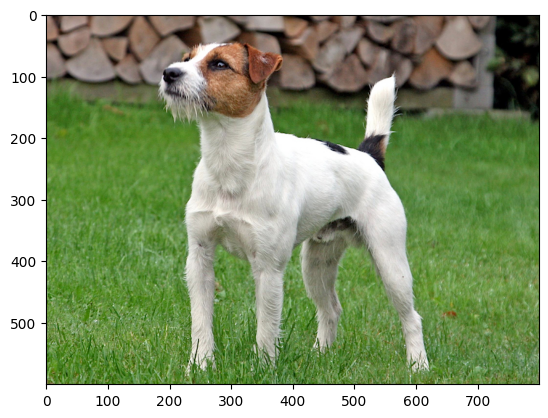

In [10]:
image = transform(Image.open('network_vis/dog.jpg')) # load dog image and transform as specified above
plt.imshow(plt.imread('network_vis/dog.jpg')) # show image

predictions = model(image.unsqueeze(0)).detach().numpy()[0] # get predictions

print('Ranking: class (score)') # print out rankings
for i, idx in enumerate(np.argsort(predictions)[-10:][::-1]): # print first 10
    print('%d: %s (%.04f)' % (
            i,
            class_idx[str(idx)][1],
            predictions[idx]))

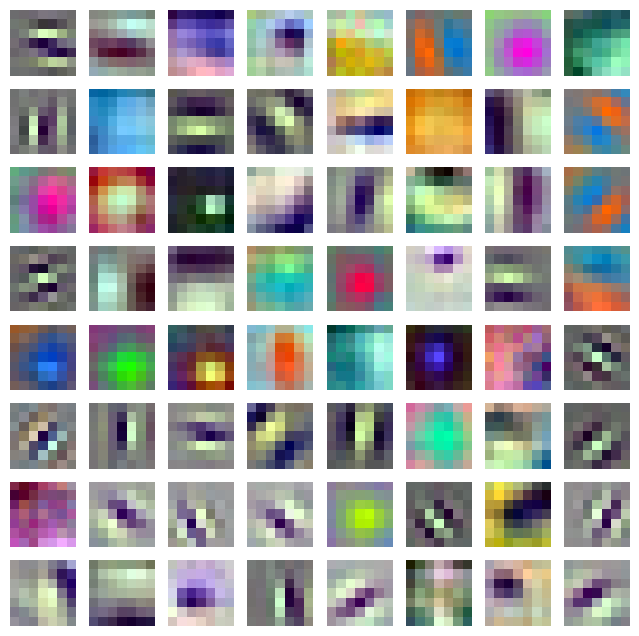

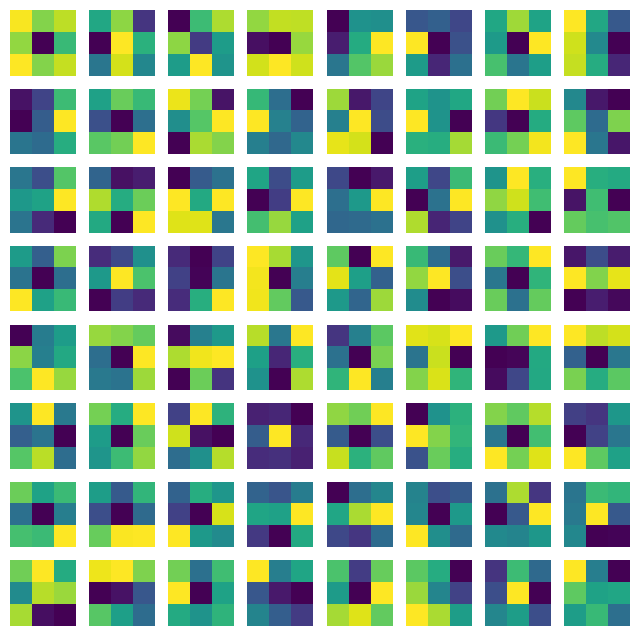

In [11]:
def visualize_layer(weight): # visualize the layer (filters model has learned)
    fig=plt.figure(figsize=(8, 8))

    for i in range(64):
        x = weight[i, ...].transpose([1, 2, 0])
        x = (x - np.min(x))/np.ptp(x)

        fig.add_subplot(8, 8, i + 1)
        if x.shape[2] == 3:
            imshow(x)
        else:
            imshow(x[:,:,0])
        axis('off')

    show()

visualize_layer(model.conv1.weight.data.cpu().numpy()) # Looks at colors and contours in first layer
visualize_layer(model.layer1[0].conv1.weight.data.cpu().numpy()) # Look at filters for next layer

In [12]:
import sys # load in dog and cat images
sys.path.append('..')
sys.path.append('../..')
from data import load
valid_data = load.get_dogs_and_cats('valid', resize=None, batch_size=128, is_resnet=True)

In [13]:
def undo_transform(x): # function that displays dog and cat images after already loading them
    mean = np.array([0.485, 0.456, 0.406])[np.newaxis, :, np.newaxis, np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[np.newaxis, :, np.newaxis, np.newaxis]
    return (x * std) + mean


In [14]:
all_data = []
C1 = []
C2 = []
C3 = []

def store_activation(L, m, grad_in, grad_out):
    L.append(grad_out.detach().cpu().numpy())

model.to(device)

try:
    h1 = model.conv1.register_forward_hook(lambda *args: store_activation(C1, *args)) # first conv. layer
    h2 = model.layer1[0].conv1.register_forward_hook(lambda *args: store_activation(C2, *args)) # first block of network
    h3 = model.layer2[0].conv1.register_forward_hook(lambda *args: store_activation(C3, *args)) # 4th block

    for it, (data, label) in enumerate(valid_data):
        all_data.append(undo_transform(data.numpy()))
        if device is not None:
            data, label = data.to(device), label.to(device)
        result = model(data)
finally:
    h1.remove()
    h2.remove()
    h3.remove()

all_data = np.vstack(all_data)
C1 = np.vstack(C1)
C2 = np.vstack(C2)
C3 = np.vstack(C3)

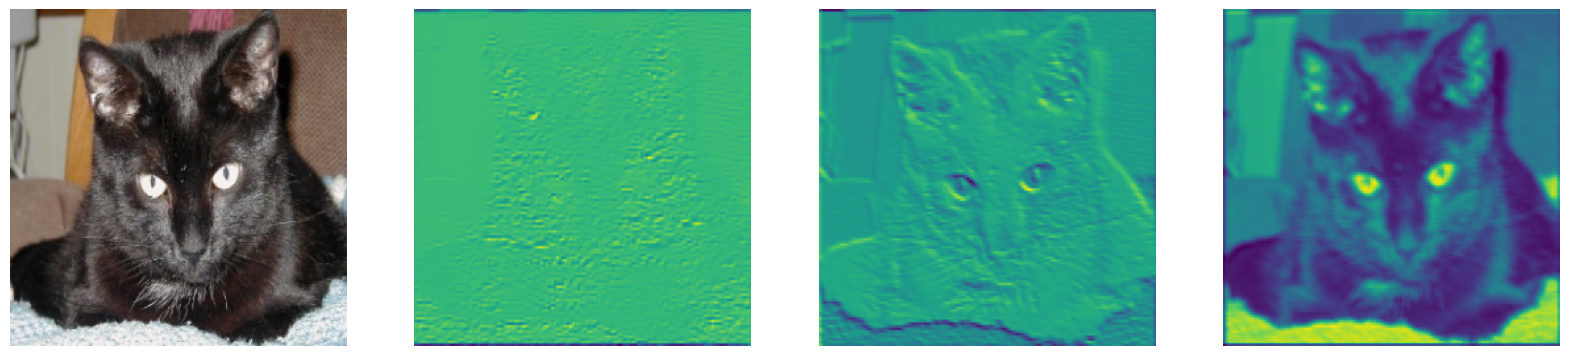

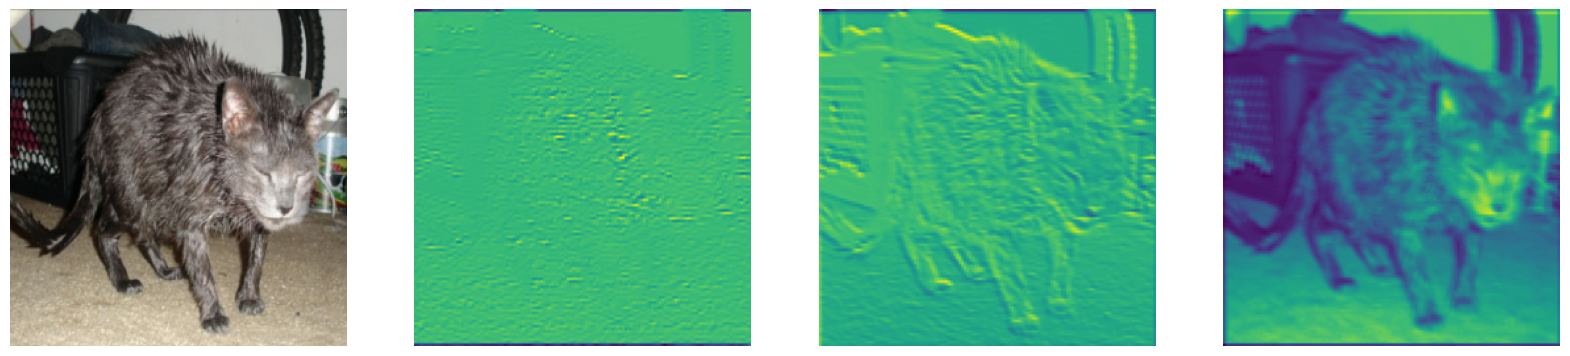

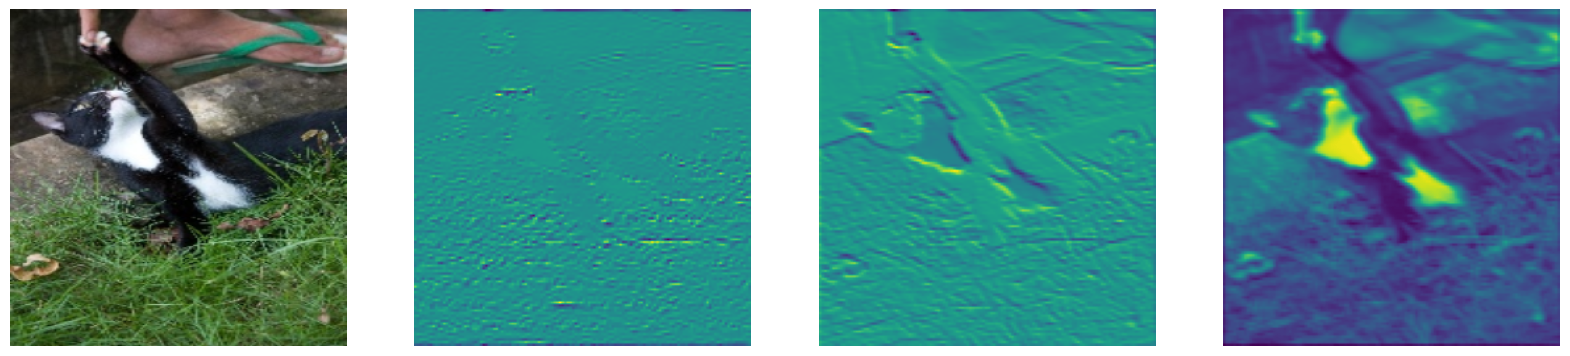

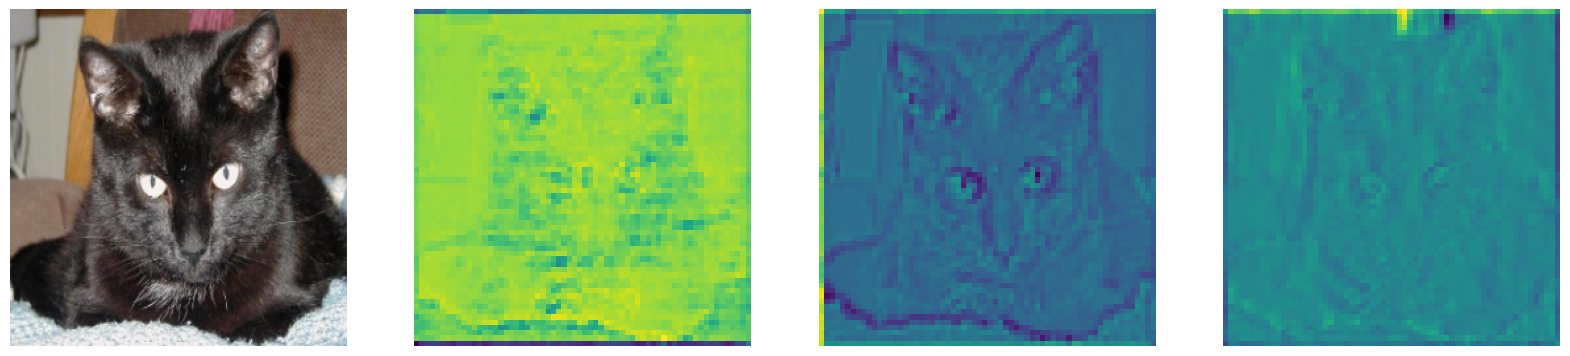

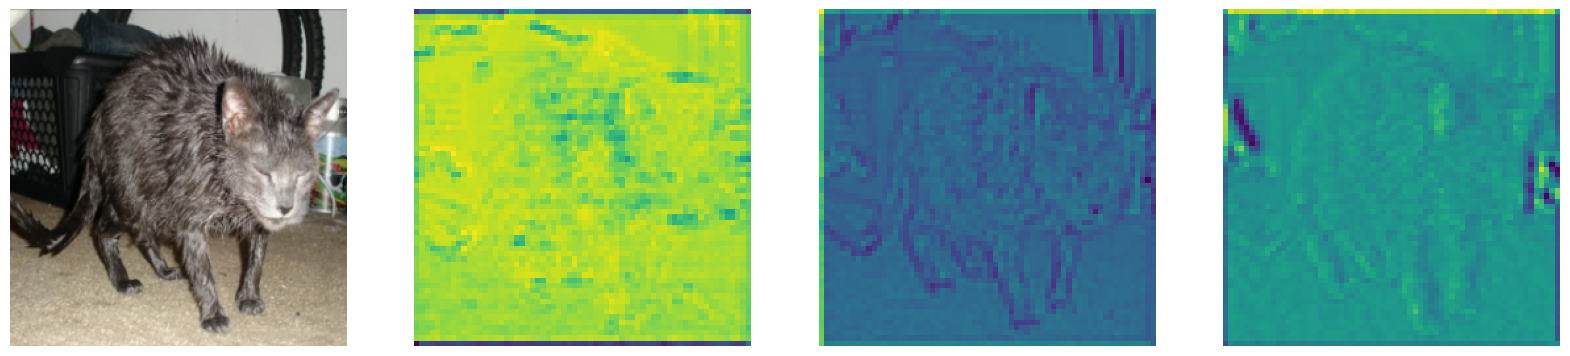

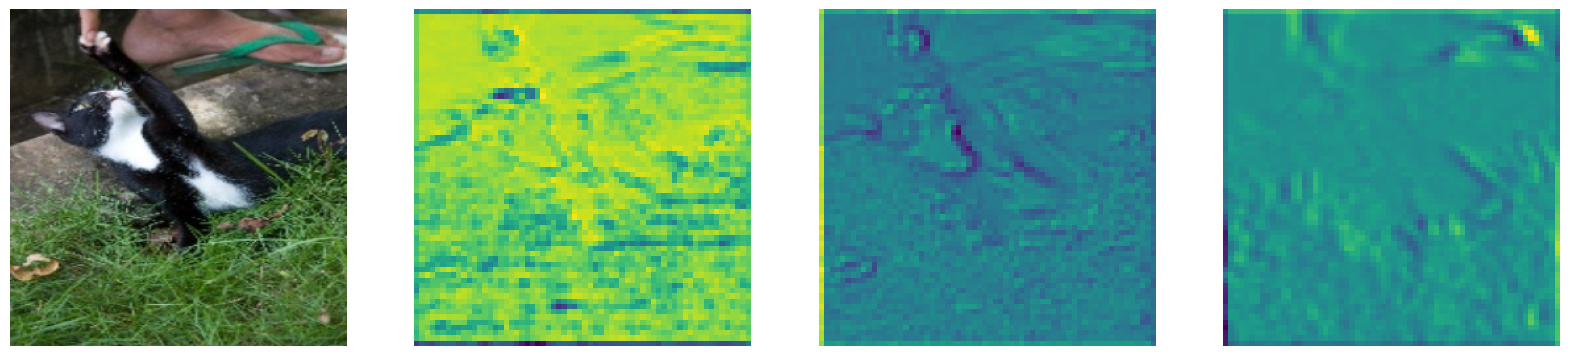

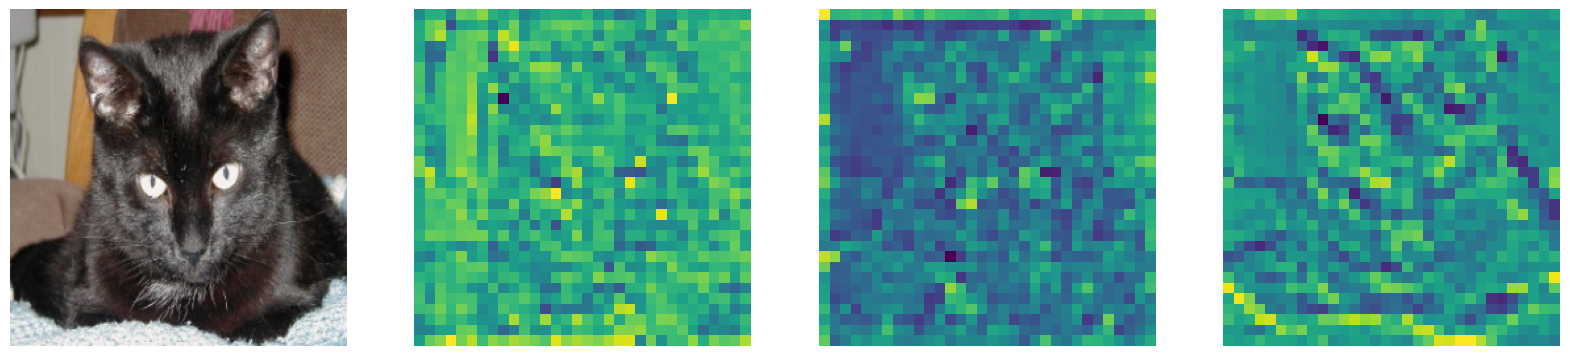

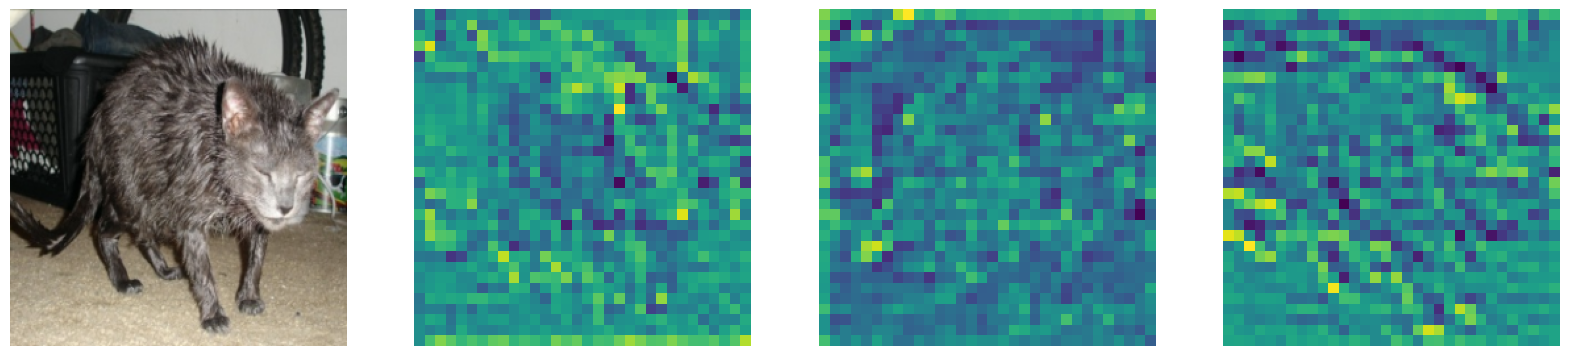

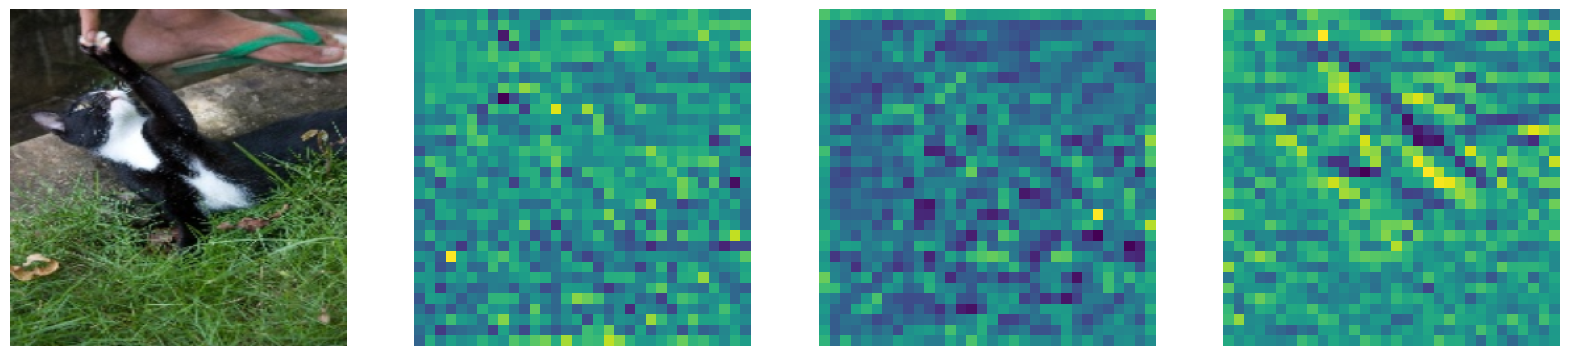

In [15]:
def to_pil(x):
    x = x.transpose((1, 2, 0))
    x -= x.min(0).min(0)[None,None]
    x /= x.max(0).max(0)[None,None]
    return Image.fromarray((x * 255).astype('uint8'))

def viz_act(img, act): # visualizing the filters

    num_acts = len(act)
    img = to_pil(img)

    fig=plt.figure(figsize=(20, 20))

    fig.add_subplot(1, 1+num_acts, 1)
    imshow(img)
    axis('off')

    for i, c in enumerate(act):
        fig.add_subplot(1, 1+num_acts, i + 2)
        imshow(c)
        axis('off')

    show()

for i in range(3):
    viz_act(all_data[i], C1[i, :3])


for i in range(3):
    viz_act(all_data[i], C2[i, :3])

for i in range(3):
    viz_act(all_data[i], C3[i, :3])

    # first set of 3 cats = first convolution
    # second set  = second convolution, trying to combine patterns
    # third set

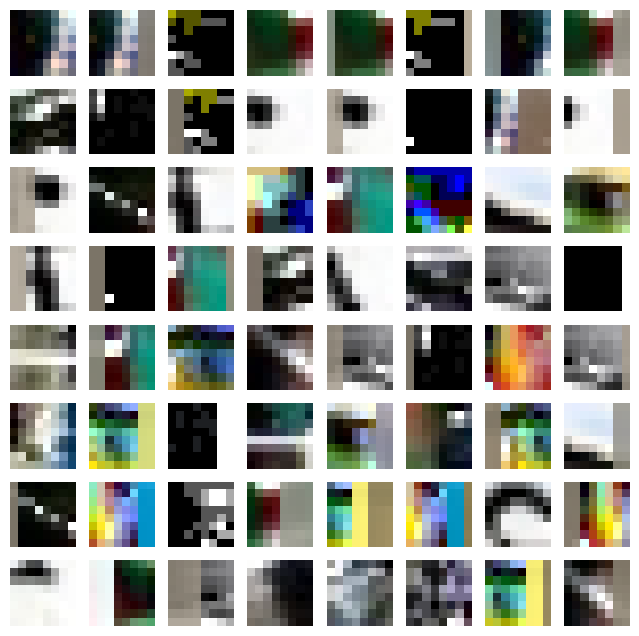

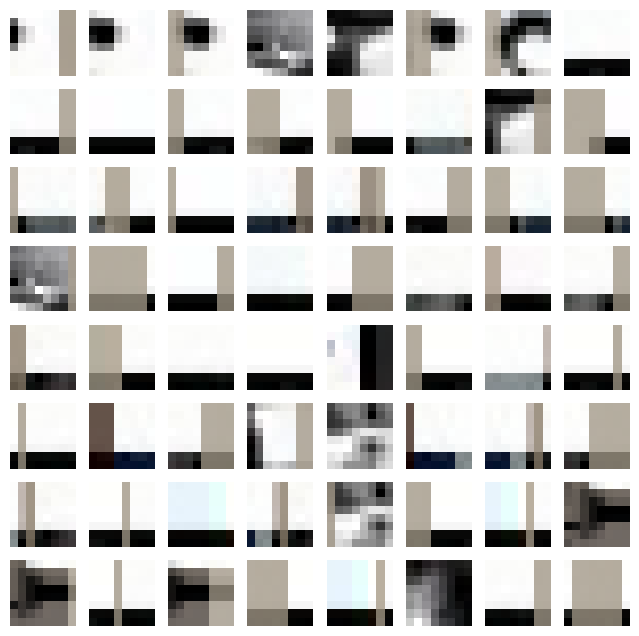

<ipython-input-15-f60fcbb8c473>:4: RuntimeWarning: invalid value encountered in divide
  x /= x.max(0).max(0)[None,None]


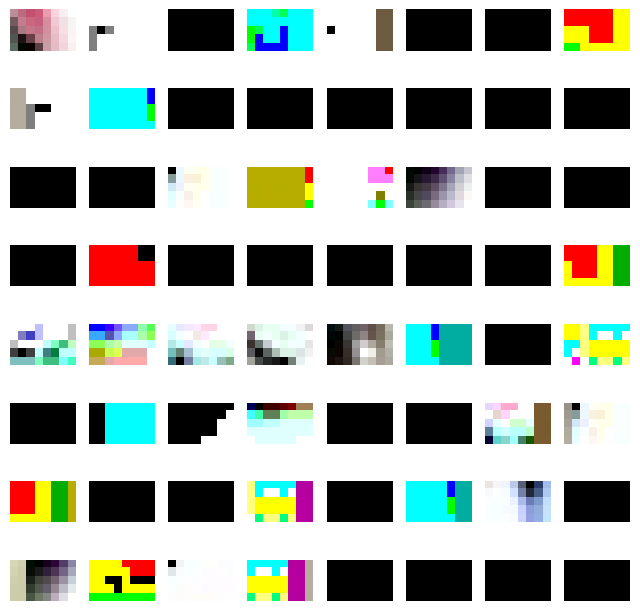

In [16]:
def find_max_act(C, filter, W=10, img_size=[224, 224]): # find what activations like to focus on
    fig=plt.figure(figsize=(8, 8))

    filter_act = C[:, filter]
    for i, idx in enumerate(np.argsort(-filter_act, axis=None)[:64]):
        max_pos = list(np.unravel_index(idx, filter_act.shape))

        max_pos[1] = int(max_pos[1] * float(img_size[0]) / filter_act.shape[1])
        max_pos[2] = int(max_pos[2] * float(img_size[1]) / filter_act.shape[2])

        img = to_pil(all_data[max_pos[0],
                              :,
                              max(max_pos[1] - W, 0) : max_pos[1] + W,
                              max(max_pos[2] - W, 0) : max_pos[2] + W])

        fig.add_subplot(8, 8, i + 1)
        imshow(img)
        axis('off')

    show()

find_max_act(C1, filter=0, W=4)#, img_size=img.size)
find_max_act(C1, filter=1, W=4)#, img_size=img.size)
find_max_act(C1, filter=2, W=4)#, img_size=img.size)

<ipython-input-15-f60fcbb8c473>:4: RuntimeWarning: invalid value encountered in divide
  x /= x.max(0).max(0)[None,None]


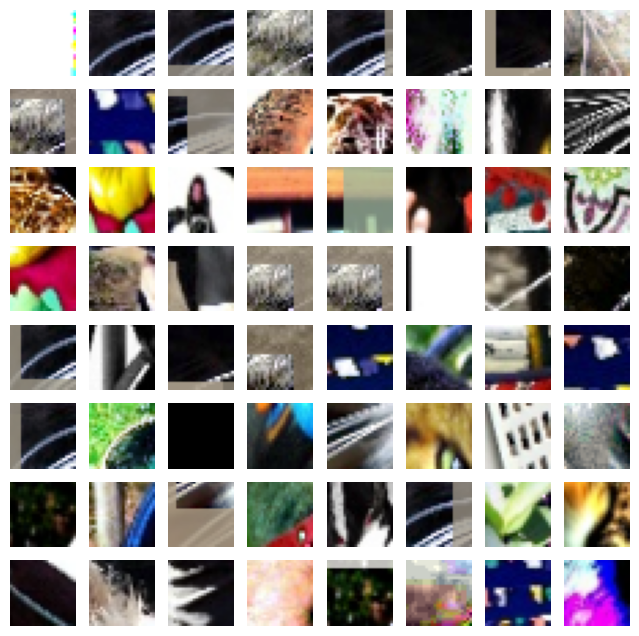

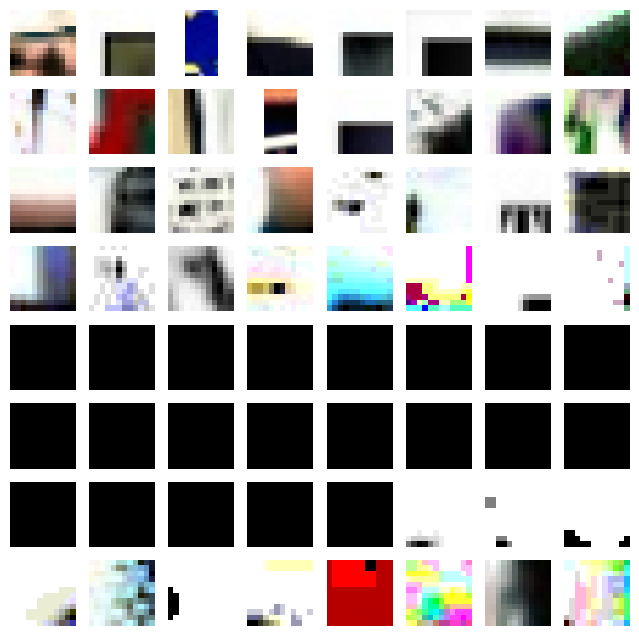

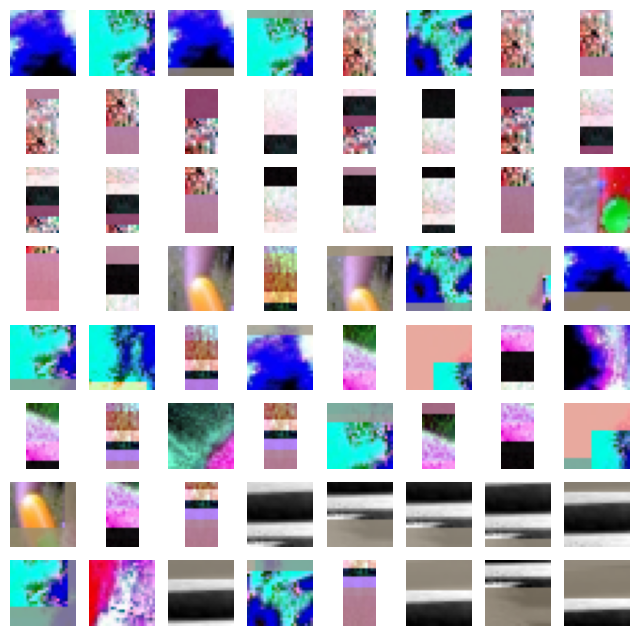

In [17]:
# first 3 units of second convo layer
find_max_act(C2, filter=0, W=12)#, img_size=img.size)
find_max_act(C2, filter=1, W=12)#, img_size=img.size)
find_max_act(C2, filter=2, W=12)#, img_size=img.size) # 3rd really likes bright colors

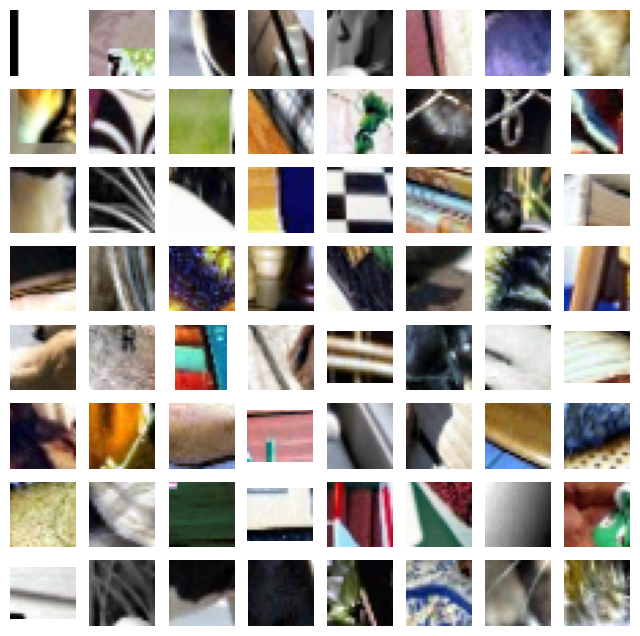

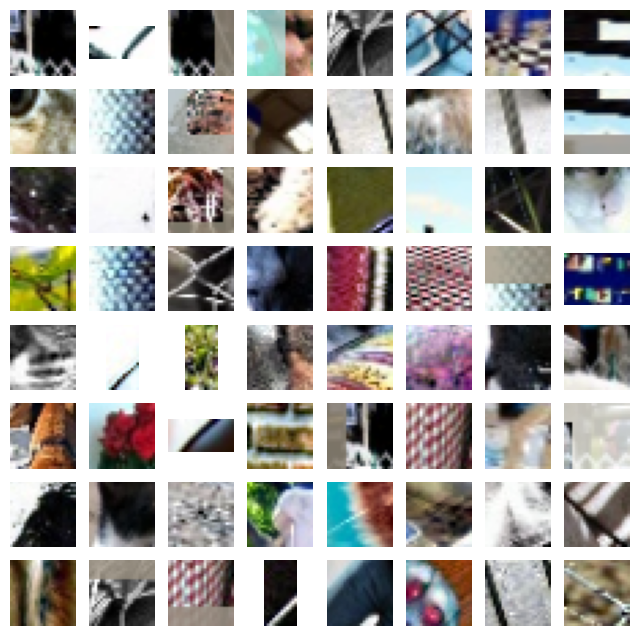

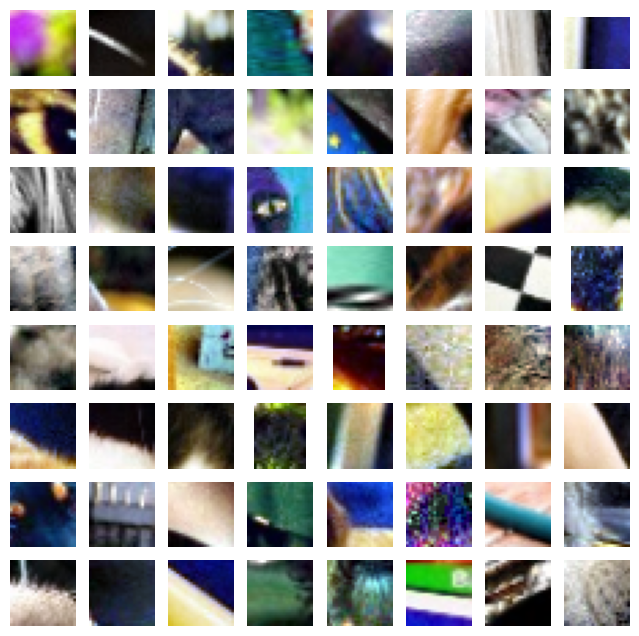

In [18]:
# go one more layer up
find_max_act(C3, filter=0, W=12)#, img_size=img.size) # likes long diagonal lines
find_max_act(C3, filter=1, W=12)#, img_size=img.size) # likes checkerboard patterns
find_max_act(C3, filter=2, W=12)#, img_size=img.size) # likes fuzzy/round objects

# As you keep going up, you see more and more semantics emerge
# go from lines to larger objects